In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import gdown
from zipfile import ZipFile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

데이터 읽기

In [ ]:
dataset = keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/four class original 모두 두배로", label_mode=None, image_size=(120, 160), batch_size=128
)
dataset = dataset.map(lambda x: x / 255.0)

Found 10003 files belonging to 1 classes.


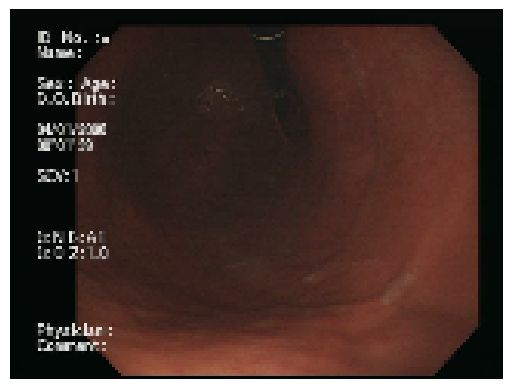

In [ ]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

In [ ]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(120, 160, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 80, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 60, 80, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 40, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 30, 40, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 20, 128)       262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 15, 20, 128)       0         
                                                                 
 flatten (Flatten)           (None, 38400)           

In [ ]:
latent_dim = 32

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(15 * 20 * 32),
        layers.Reshape((15, 20, 32)),
        layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 9600)              316800    
                                                                 
 reshape (Reshape)           (None, 15, 20, 32)        0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 30, 40, 32)        16416     
 anspose)                                                        
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 30, 40, 32)        0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 60, 80, 64)        32832     
 Transpose)                                                      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 60, 80, 64)        0 

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=32):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        if epoch == epochs - 1:
            for i in range(self.num_img):
                img = keras.utils.array_to_img(generated_images[i])
                img.save("project1/generated_img_%03d_%d.png" % (epochs, i))

In [ ]:
os.makedirs("project1")

In [ ]:
epochs = 20

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=100, latent_dim=latent_dim)]
)

Epoch 1/20
79/79 [==============================] - 99s 900ms/step - d_loss: -0.0952 - g_loss: 56.3905
Epoch 2/20
79/79 [==============================] - 69s 800ms/step - d_loss: 0.7051 - g_loss: 48.5988
Epoch 3/20
79/79 [==============================] - 70s 802ms/step - d_loss: 0.0104 - g_loss: 8.5150
Epoch 4/20
79/79 [==============================] - 69s 806ms/step - d_loss: 0.0480 - g_loss: 11.6312
Epoch 5/20
79/79 [==============================] - 68s 807ms/step - d_loss: 0.2132 - g_loss: 11.4737
Epoch 6/20
79/79 [==============================] - 68s 798ms/step - d_loss: 0.1563 - g_loss: 14.9330
Epoch 7/20
79/79 [==============================] - 68s 802ms/step - d_loss: 0.7055 - g_loss: 9.4526
Epoch 8/20
79/79 [==============================] - 68s 805ms/step - d_loss: 0.1316 - g_loss: 4.8254
Epoch 9/20
79/79 [==============================] - 68s 805ms/step - d_loss: 0.4286 - g_loss: 4.8252
Epoch 10/20
79/79 [==============================] - 69s 805ms/step - d_loss: 0.1768 

평가 지표

In [ ]:
import matplotlib.pyplot as plt
import cv2
import random

In [ ]:
images = []
for i in range(100):
  images.append(cv2.imread("project1/generated_img_%03d_%d.png" % (epochs, i)))

In [ ]:
def find_images_in_directory(directory):
    image_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith((".jpg")):
                image_files.append(os.path.join(root, file))
    return image_files

In [ ]:
image_directory = "/content/drive/MyDrive/four class original 모두 두배로"
image_files = find_images_in_directory(image_directory)

In [ ]:
original_images = []
for i in range(10):
  random.seed(i)
  random_image_path = random.choice(image_files)
  original_img = cv2.imread(random_image_path)
  original_img = cv2.resize(original_img, (160, 120))
  original_images.append(original_img)

In [ ]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

psnr = 0
ssim = 0

for i in range(10):
  for j in range(100):
    # PSNR
    psnr += peak_signal_noise_ratio(original_images[i], images[j])
    # SSIM
    ssim += structural_similarity(original_images[i], images[j], multichannel=True)

<ipython-input-18-ac9052169105>:11: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim += structural_similarity(original_images[i], images[j], multichannel=True)


In [ ]:
# 반올림(소수점 3자리까지)
psnr = round(psnr/1000, 3) # i 10번, j 10번 -> 총 100번
ssim = round(ssim/1000, 3)

In [ ]:
print(f"psnr = {psnr}")
print(f"ssim = {ssim}")

psnr = 11.804
ssim = 0.151
